# Etape 2 : Préparation des données pour notre algorithme de machine learning et Modélisation

In [25]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PolynomialFeatures
from math import sqrt
from sklearn.compose import make_column_selector,make_column_transformer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import pickle

In [26]:
df = pd.read_csv("cleared_data.csv")

# 1.Pipelines

# 1.1 One Hot Encoding et Scaling de nos données

## 1.1.A One Hot Encoding

##### Après avoir catégoriser nos variables et choisi celles qui étaient pertinentes à notre modèle (étape 1), on va transformer nos variables qualitatives qui ont des taux de correlations très bas pour qu'elles soient ajuster à notre modèle. Pour transformer nos données on va utilise le one-hot encoding , on va convertir les valeurs associées à nos variables en de nouvelles colonnes de variables et on leur assigne une valeur binaire 1 pour présent et 0 pour non existant.


##### On va les transformer en type str pour séparer nos variables numériques et catégoriques.


In [27]:

liste = ["zipcode","grade","waterfront","condition","renovated","view"]

## 1.1.B Scaling

##### En effet certaines de données sont beaucoup plus grandes que d'autres et on ne voudrait pas que le poids de leurs influences soient trop grandes.

### I) Normalisation ou Standardisation ?


##### On sait que si on ne connait pas notre jeu de donnée on peut utiliser la normalisation et que si nos données ont une distribution gaussienne , la standardisation est plus optimisé. Dans l'étape 1 on a utilisé des histogrammes pour comprendre la distribution de nos variables et ainsi les nettoyer, ici nous allons observer la distribution de nos variables avec un diagramme de densité c'est un module de matplotlib qui permet d'obtenir une version lissé et continue d'un histogramme pour mieux la visualiser.

IndexError: index 3 is out of bounds for axis 0 with size 3

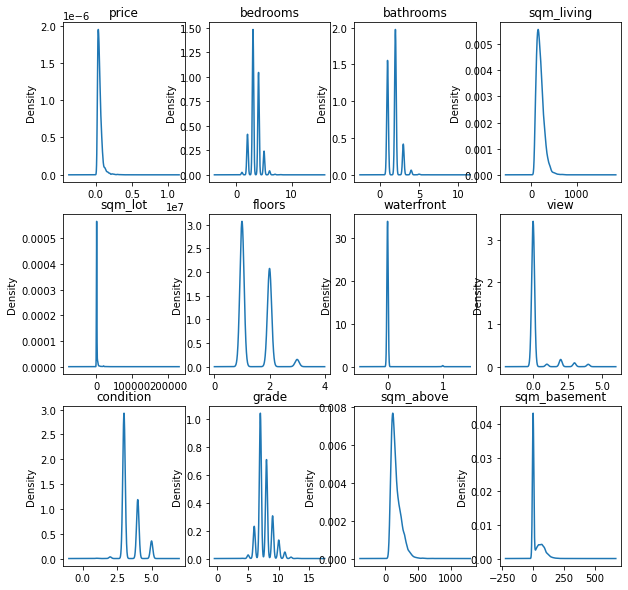

In [28]:
fig,ax = plt.subplots(3,4,figsize=(10,10))
row = col = 0
for n,c in enumerate(df.columns):
    if (n%4 == 0) & (n > 0):
        row += 1
        col = 0
    df[c].plot(kind="kde",ax=ax[row,col])
    ax[row,col].set_title(c)
    col += 1
#Erreurs due au faite qu'il y'a des des colonnes qui ont été changer en str

On remarque que la plupart de nos variables numériques ont une distribution gaussienne , on va donc choisir la méthode de standardisation.

# 1.2 Création d'une pipeline

Une pipeline est une chaine de transformation ,elle va nous permettre de faire plusieurs action de transformation sur nos données.

On a au préalables séparer nos variables en deux catégories les valeurs numériques et catégoriques, on va ainsi pouvoir créer deux pipelines. 
Ici notre target est le prix de l'immobilier en fonction des autres paramètres.

In [ ]:
X = df.drop('price', axis=1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [ ]:

numerical_features =list(X.drop(liste,axis=1))
categorical_features =list(X[liste])


In [ ]:
categorical_features

['zipcode', 'grade', 'waterfront', 'condition', 'renovated', 'view']

In [ ]:

my_num_pipe = make_pipeline(StandardScaler(), PolynomialFeatures())
preprocessor = ColumnTransformer([
    ("one_hot", OneHotEncoder(handle_unknown='ignore'),categorical_features),
    ("scaling", my_num_pipe, numerical_features)
])


# 2.Modélisation

##### Après avoir créer notre premier transformeur composé des deux pipelines (OneHotEncoding,Standardisation), nous allons maintenant nous attaqué aux différents types de régression linéaire pour ajuster notre modèle.

## 2.1 Les algorithmes de régressions linéaire 

### I) Linear Regression

In [29]:
lr_pipeline = make_pipeline(preprocessor,LinearRegression())
lr_pipeline.fit(X_train,y_train)
lr_pipeline.score(X_test,y_test)

0.8249075519003027

### II) Lasso Regression

In [30]:
lasso_pipeline= make_pipeline(preprocessor,Lasso(random_state=0,alpha=0.6))
lasso_pipeline.fit(X_train,y_train)
lasso_pipeline.score(X_test, y_test)


/home/jynmoriarty/miniconda3/envs/pdb/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e+14, tolerance: 2.311e+11
  model = cd_fast.enet_coordinate_descent(


0.8268168312643622

In [31]:
lasso_pred = lasso_pipeline.predict(X_train)


#### II.A) Cherchez les meilleurs paramètre pour notre lasso regression

In [32]:
lasso_alphas={"alpha":np.arange(0.1,1,0.5)}
model_lasso = GridSearchCV(estimator = Lasso() ,cv=5,scoring="r2",verbose=False,param_grid=lasso_alphas)

In [33]:
model_lasso.fit(X_train,y_train)


/home/jynmoriarty/miniconda3/envs/pdb/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.960e+14, tolerance: 1.741e+11
  model = cd_fast.enet_coordinate_descent(
/home/jynmoriarty/miniconda3/envs/pdb/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.202e+14, tolerance: 1.887e+11
  model = cd_fast.enet_coordinate_descent(
/home/jynmoriarty/miniconda3/envs/pdb/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': array([0.1, 0.6])},
             scoring='r2', verbose=False)

In [34]:
bl_alpha=model_lasso.best_params_["alpha"]

In [35]:
lasso_pipeline = make_pipeline(preprocessor,Lasso(alpha=bl_alpha))

In [36]:
residual_lasso = (y_train - lasso_pred).abs().sort_values()

/home/jynmoriarty/miniconda3/envs/pdb/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


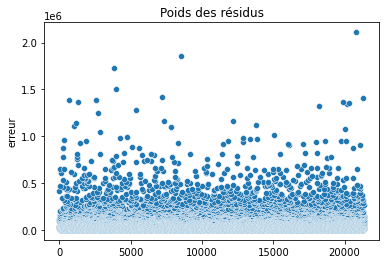

In [37]:
sns.scatterplot(residual_lasso.index, residual_lasso)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

### III) Ridge Regression

In [38]:
R_pipeline = make_pipeline(preprocessor,Ridge(random_state=0,alpha=0.1))
R_pipeline.fit(X_train,y_train)
R_pipeline.score(X_test,y_test)

0.8253524685197464

### IV) Elastic Regression

In [39]:
eN_pipeline= make_pipeline(preprocessor,ElasticNet(random_state=0,alpha=0.0001))
eN_pipeline.fit(X_train,y_train)
eN_pipeline.score(X_test, y_test)

/home/jynmoriarty/miniconda3/envs/pdb/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+14, tolerance: 2.311e+11
  model = cd_fast.enet_coordinate_descent(


0.827158623595346

# 3.Conversion de nos fichiers pour l'exportation sur Streamlit

In [40]:
pickle_out = open("modellr.pkl", "wb") 
pickle.dump(lr_pipeline, pickle_out) 
pickle_out.close()
pickle_out2 = open("modelRid.pkl", "wb") 
pickle.dump(R_pipeline, pickle_out2) 
pickle_out2.close()
pickle_out3 = open("modelLasso.pkl", "wb") 
pickle.dump(lasso_pipeline, pickle_out3) 
pickle_out3.close()
pickle_out4 = open("modelEN.pkl", "wb") 
pickle.dump(eN_pipeline, pickle_out4) 
pickle_out4.close()
